In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Specifying dtypes helps reduce memory requirements for reading in csv file later.

In [3]:
# data_type={'is_booking':bool,'srch_ci' : np.str_, 'srch_co' : np.str_,
           'srch_adults_cnt' : np.int32, 'srch_children_cnt' : np.int32,
           'srch_rm_cnt' : np.int32, 'srch_destination_id':np.int32,
           'user_location_country' : np.int32, 'user_location_region' : np.int32,
           'user_location_city' : np.int32, 'hotel_cluster' : np.int32,
           'orig_destination_distance':np.float64, 'date_time':np.str_,
           'hotel_market':np.int32}
# d_type={'is_booking':bool, 'cnt':np.int32, 'hotel_cluster' : np.int32,'srch_destination_id':np.int32}

To be able to process locally, we randomly sample 1% of the records. After that, we still have a large number of records at 241,179.

In [2]:
df = pd.read_csv('train.csv.gz', sep=',').dropna()
dest = pd.read_csv('destinations.csv.gz')
df = df.sample(frac=0.01, random_state=99)
df.shape

(241179, 24)

In [3]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


### EDA

#### What are we predicting?
The objective is to predict which hotel_cluster a user will book given the information in their search. There are 100 clusters in total. In another word, we are dealing with a 100 class classification problem.

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


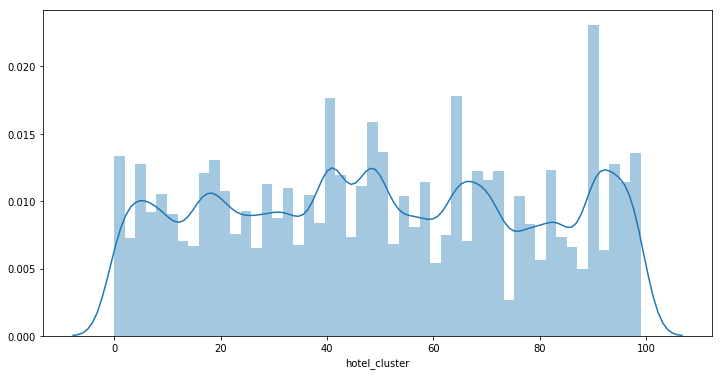

In [4]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

The data is pretty much well distributed over all 100 clusters and there is skewness in the data.

### Feature Engineering

In [5]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [9]:
# msk = np.random.rand(len(df)) < 0.8
# train = df[msk]
# test = df[~msk]

In [6]:
# dealing with date_time column

df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)

from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))

del df['date_time']

In [7]:
# work on srch_ci column

df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)

# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))

# remove the srch_ci column
del df['srch_ci']

In [8]:
# work on srch_co column

df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)

# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))

# remove the srch_co column
del df['srch_co']

In [9]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
32352134,2,3,66,174,24103,2323.5232,802499,0,1,9,...,4,125,177,44,2014,5,2014,7,2014,7
29796021,2,3,66,311,25538,2288.6121,85229,0,0,9,...,2,50,659,59,2013,6,2013,7,2013,7
15185156,2,3,66,294,40046,587.6970,755217,0,1,9,...,2,50,642,22,2014,10,2014,12,2014,12
3301948,2,3,66,332,55121,2234.4394,160733,0,1,9,...,4,47,1502,65,2014,8,2015,1,2015,1
25429119,2,3,66,314,47869,839.0087,1078493,0,0,9,...,2,50,685,6,2014,3,2014,4,2014,4


### Any correlations?
We want to know if anything correlates well with hotel_cluster .This will tell us if we should pay more attention to any particular columns.

In [14]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.036120
site_name                   -0.027497
hotel_country               -0.023837
is_booking                  -0.022898
user_location_country       -0.020239
srch_destination_id         -0.016736
srch_co_month               -0.005874
srch_rm_cnt                 -0.005570
srch_ci_month               -0.005015
date_time_month             -0.002142
channel                     -0.001386
date_time_year              -0.000435
cnt                          0.000378
hotel_continent              0.000422
user_location_city           0.001241
user_id                      0.003891
orig_destination_distance    0.006084
user_location_region         0.006927
srch_ci_year                 0.008562
is_mobile                    0.008788
srch_co_year                 0.009287
posa_continent               0.012180
srch_adults_cnt              0.012407
srch_children_cnt            0.014901
hotel_market                 0.022149
is_package                   0.047598
hotel_cluste

No column correlates linearly with hotel_cluster, this means that linear regression and logistic regression won't work well on our data.

In [10]:
df.shape

(241179, 27)

For known combinations of user location cities, origin-destination distances and search destinations, will definitely help finding hotel cluster.

In [11]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

In [12]:
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               0      1
                                               29               0      1
                                               30               0      1
                                               32               1      2
                                               43               0      1

In [13]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)

In [14]:
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,4,7,246,22,0.0,0.125,0.073171
1,4,7,246,29,0.0,0.125,0.073171
2,4,7,246,30,0.0,0.125,0.073171
3,4,7,246,32,1.0,0.250,0.560976
4,4,7,246,43,0.0,0.125,0.073171


In [15]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()

In [16]:
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,4,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.344828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [18]:
df.fillna(0, inplace=True)

In [19]:
df.shape

(241179, 276)

We are only interested in booking events.

In [20]:
df = df.loc[df['is_booking'] == 1]

In [21]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

In [22]:
X.shape, y.shape

((20032, 273), (20032,))

In [23]:
y.nunique()

100

### Random Forest

In [29]:
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.24865023372782996

### SVM

In [28]:
from sklearn import svm

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, X, y, cv=10))

0.3228727137315005

### Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, X, y, cv=10))

0.10347912437041926

### Multi-class Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, X, y, cv=10))

0.30445543572367767

### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.25631461834732266